<a href="https://colab.research.google.com/github/alex-w-yoo/retail-sales-eda-py/blob/main/CS667_Project1_Alex_Yoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project1 - CS667 – Practical Data Science (CRN: 72872) - Alexander YOO

In [ ]:
import os
import sys
import math
import warnings
warnings.filterwarnings("ignore")

!pip install holidays
import holidays

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# 1) Load Data


In [ ]:
FILE_PATH = "/content/sample_data/retail_sales.xlsx"
assert os.path.exists(FILE_PATH), f"File not found at {FILE_PATH}"

xls = pd.ExcelFile(FILE_PATH)
dfs = []
for s in xls.sheet_names:
    df_tmp = pd.read_excel(FILE_PATH, sheet_name=s)
    df_tmp["__sheet__"] = s
    dfs.append(df_tmp)
df = pd.concat(dfs, ignore_index=True)

print("Loaded shape:", df.shape)
print("Columns:", list(df.columns))
print(df.head(3))

Loaded shape: (1000, 10)
Columns: ['Transaction ID', 'Date', 'Customer ID', 'Gender', 'Age', 'Product Category', 'Quantity', 'Price per Unit', 'Total Amount', '__sheet__']
   Transaction ID       Date Customer ID  Gender  Age Product Category  \
0               1 2023-11-24     CUST001    Male   34           Beauty   
1               2 2023-02-27     CUST002  Female   26         Clothing   
2               3 2023-01-13     CUST003    Male   50      Electronics   

   Quantity  Price per Unit  Total Amount             __sheet__  
0         3              50           150  retail_sales_dataset  
1         2             500          1000  retail_sales_dataset  
2         1              30            30  retail_sales_dataset  


# 2) Standardize Column Names & Expected Schema


In [ ]:
def to_snake(s):
    return (
        str(s)
        .strip()
        .replace("#", "num")
        .replace("%", "pct")
        .replace("/", "_")
        .replace("-", "_")
        .replace(" ", "_")
        .lower()
    )
df.columns = [to_snake(c) for c in df.columns]

col_map_candidates = {
    "transaction_id": ["transaction_id", "trans_id", "id", "transaction"],
    "date": ["date", "order_date", "transaction_date", "datetime"],
    "customer_id": ["customer_id", "cust_id", "user_id", "client_id"],
    "gender": ["gender", "sex"],
    "age": ["age", "customer_age"],
    "product_category": ["product_category", "category", "product_cat", "productgroup"],
    "quantity": ["quantity", "qty", "units"],
    "price_per_unit": ["price_per_unit", "unit_price", "price"],
    "total_amount": ["total_amount", "amount", "total", "sales", "revenue"],
}

resolved = {}
for std_name, variants in col_map_candidates.items():
    for v in variants:
        if v in df.columns:
            resolved[std_name] = v
            break

for std_name in col_map_candidates.keys():
    if std_name not in resolved:
        print(f"[WARN] Could not resolve column for '{std_name}'. You'll need to adjust manually if it's truly missing.")
        resolved[std_name] = None

def col(name):
    key = resolved.get(name)
    return key if (key is not None and key in df.columns) else None


# 3) Basic Cleaning & Type Casting


In [ ]:
date_col = col("date")
if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
else:
    df["__fake_date__"] = pd.date_range("2023-01-01", periods=len(df), freq="D")
    resolved["date"] = "__fake_date__"
    date_col = "__fake_date__"

for num_col_std in ["age", "quantity", "price_per_unit", "total_amount"]:
    c = col(num_col_std)
    if c:
        df[c] = pd.to_numeric(df[c], errors="coerce")

if col("total_amount") is None and col("quantity") and col("price_per_unit"):
    df["total_amount"] = df[col("quantity")] * df[col("price_per_unit")]
    resolved["total_amount"] = "total_amount"

before_dup = len(df)
df = df.drop_duplicates()
print(f"Removed {before_dup - len(df)} duplicate rows")

missing_summary = df.isna().sum().sort_values(ascending=False)
print("\nMissing Values per Column:\n", missing_summary)

if col("age"):
    df[col("age")] = df[col("age")].fillna(df[col("age")].median())

critical = [date_col, col("total_amount")]
critical = [c for c in critical if c is not None]
df = df.dropna(subset=critical)

Removed 0 duplicate rows

Missing Values per Column:
 transaction_id      0
date                0
customer_id         0
gender              0
age                 0
product_category    0
quantity            0
price_per_unit      0
total_amount        0
__sheet__           0
dtype: int64


# 4) Derived Time Features


In [ ]:
d = date_col
df["year"] = df[d].dt.year
df["quarter"] = df[d].dt.quarter
df["month"] = df[d].dt.month
df["day"] = df[d].dt.day
df["dayofweek"] = df[d].dt.dayofweek  # Monday=0
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)
df["weekofyear"] = df[d].dt.isocalendar().week.astype(int)

def add_holiday_flag(frame, date_field, country="US"):
    if holidays is None:
        frame["is_holiday"] = 0
        return frame
    try:
        years = frame[date_field].dt.year.unique().tolist()
        if country == "US":
            hol = holidays.UnitedStates(years=years)
        elif country == "KR":
            hol = holidays.Korea(years=years)
        else:
            hol = holidays.UnitedStates(years=years)
        frame["is_holiday"] = frame[date_field].dt.date.astype(object).isin(hol).astype(int)
    except Exception:
        frame["is_holiday"] = 0
    return frame

df = add_holiday_flag(df, d, country="US")

# 5) Aggregations for EDA


In [ ]:
target = col("total_amount")
qty = col("quantity")
price = col("price_per_unit")
cat = col("product_category")
gender = col("gender")

# Daily and Monthly sales
daily_sales = df.groupby(df[d].dt.to_period("D"))[target].sum().to_timestamp()
monthly_sales = df.groupby(df[d].dt.to_period("M"))[target].sum().to_timestamp()

print("\nHead (daily_sales):\n", daily_sales.head())
print("\nHead (monthly_sales):\n", monthly_sales.head())


Head (daily_sales):
 date
2023-01-01    3600
2023-01-02    1765
2023-01-03     600
2023-01-04    1240
2023-01-05    1100
Name: total_amount, dtype: int64

Head (monthly_sales):
 date
2023-01-01    35450
2023-02-01    44060
2023-03-01    28990
2023-04-01    33870
2023-05-01    53150
Freq: MS, Name: total_amount, dtype: int64


# 6) Outlier Detection (IQR on Total Amount) & Flagging


In [ ]:

Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df["is_outlier_total"] = ((df[target] < lower) | (df[target] > upper)).astype(int)
print(f"\nOutlier bounds for {target}: [{lower:,.2f}, {upper:,.2f}]")
print("Outlier rate:", df["is_outlier_total"].mean().round(4))


Outlier bounds for total_amount: [-1,200.00, 2,160.00]
Outlier rate: 0.0


# 7) Rolling / Time-Decayed Features (Customer-level)


In [ ]:
cust = col("customer_id")
if cust is None:
    df["__fake_customer_id__"] = 1
    cust = "__fake_customer_id__"

df = df.sort_values([cust, d]).copy()
df[target] = df[target].fillna(0)

for w in [3, 7, 30]:
    roll_sum = (
        df.groupby(cust)
          .rolling(f"{w}D", on=d)[target]
          .sum()
          .reset_index(level=0, drop=True)
    )
    df[f"cust_amt_roll_{w}d"] = roll_sum.values

df["cust_amt_ewm_span7"] = (
    df.groupby(cust, sort=False)[target]
      .apply(lambda s: s.ewm(span=7, adjust=False).mean())
      .reset_index(level=0, drop=True)
)


In [ ]:
# Daily anomalies via z-score
daily = df.groupby('date')[target].sum().rename('sales').to_frame()
daily['z'] = (daily['sales'] - daily['sales'].mean()) / daily['sales'].std()
anomalies = daily[(daily['z'].abs() >= 3)].sort_values('z', ascending=False).head(10)
print("Top daily anomalies (|z|>=3):\n", anomalies)

Top daily anomalies (|z|>=3):
             sales         z
date                       
2023-05-23   8455  5.836660
2023-05-16   7260  4.858873
2023-06-24   6220  4.007912
2023-02-17   5890  3.737896
2023-08-05   5205  3.177407
2023-07-14   5125  3.111948


# 8) Target Encoding (simple, leakage-unsafe for demo EDA) — Category & Gender


In [ ]:
global_mean = df[target].mean()

def target_encode(series, y, min_samples_leaf=10, smoothing=1):
    stats = y.groupby(series).agg(["mean", "count"])
    enc = (stats["count"] * stats["mean"] + smoothing * global_mean) / (stats["count"] + smoothing)
    return series.map(enc).fillna(global_mean)

if cat:
    df["product_category_te"] = target_encode(df[cat], df[target], min_samples_leaf=10, smoothing=5)
if gender:
    df["gender_te"] = target_encode(df[gender], df[target], min_samples_leaf=10, smoothing=5)

In [ ]:
from sklearn.impute import KNNImputer

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
safe_num_cols = [c for c in num_cols if c not in []]

if len(safe_num_cols) > 0:
    imputer = KNNImputer(n_neighbors=5)
    df[safe_num_cols] = imputer.fit_transform(df[safe_num_cols])

# 9) Visualization — Trends, Seasonality, Distributions


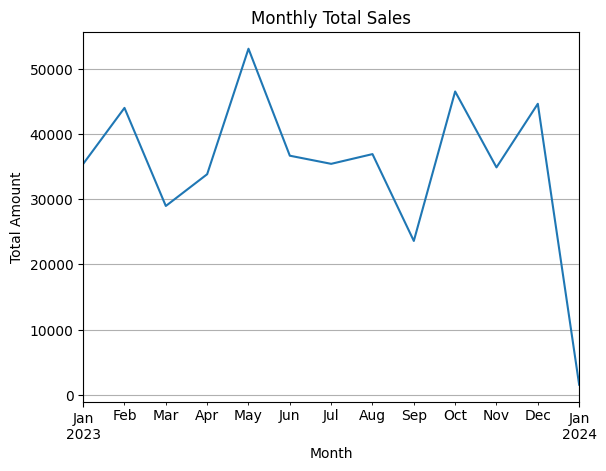

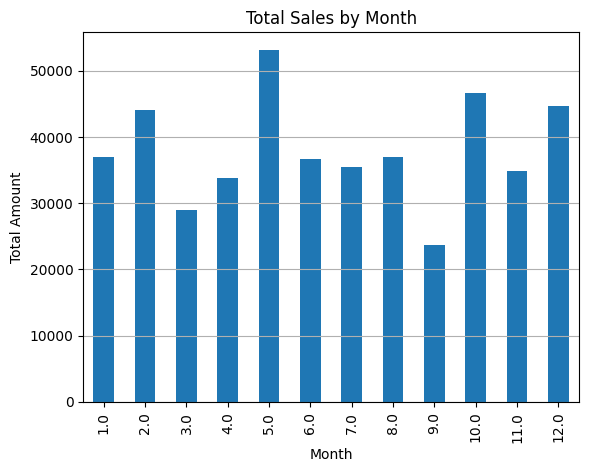

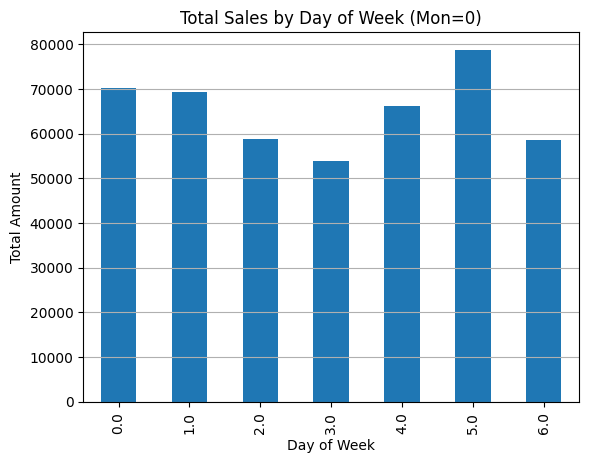

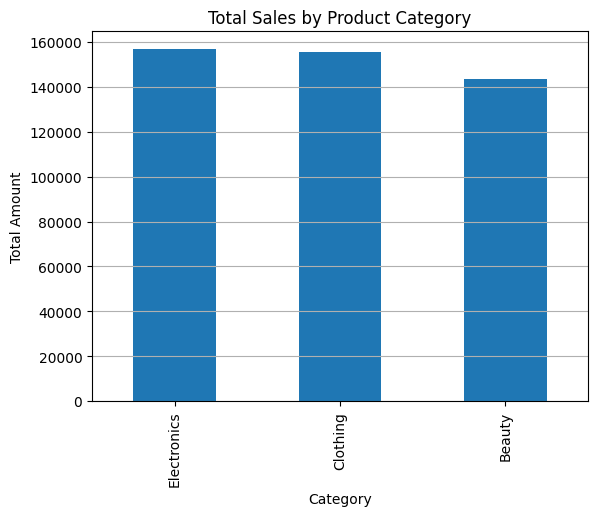

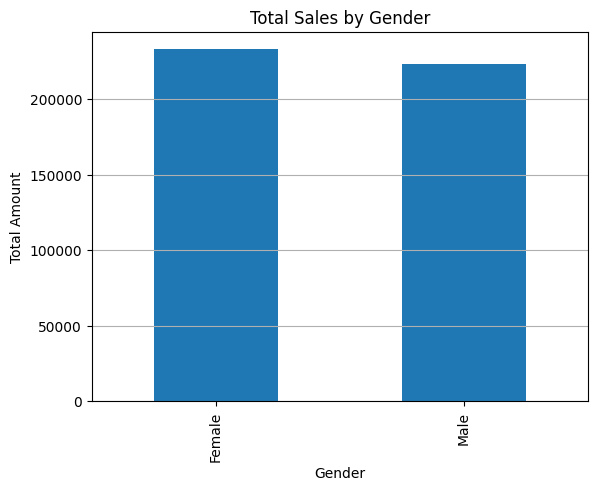

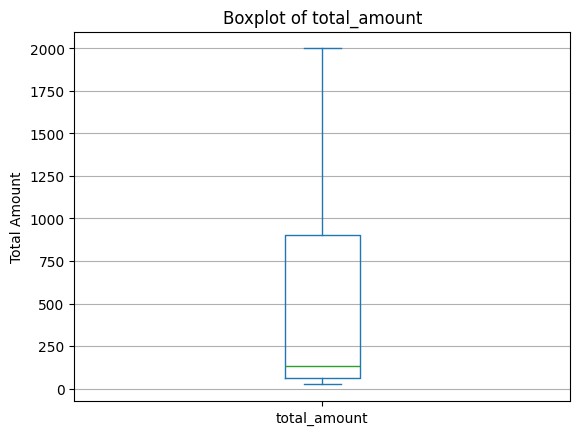

In [ ]:
# (A) Monthly sales trend
plt.figure()
monthly_sales.plot()
plt.title("Monthly Total Sales")
plt.xlabel("Month")
plt.ylabel("Total Amount")
plt.grid(True)
plt.show()

# (B) Sales by Month (Seasonality)
sales_by_month = df.groupby("month")[target].sum()
plt.figure()
sales_by_month.plot(kind="bar")
plt.title("Total Sales by Month")
plt.xlabel("Month")
plt.ylabel("Total Amount")
plt.grid(True, axis="y")
plt.show()

# (C) Weekday pattern
sales_by_dow = df.groupby("dayofweek")[target].sum()
plt.figure()
sales_by_dow.plot(kind="bar")
plt.title("Total Sales by Day of Week (Mon=0)")
plt.xlabel("Day of Week")
plt.ylabel("Total Amount")
plt.grid(True, axis="y")
plt.show()

# (D) Category contribution (if present)
if cat:
    sales_by_cat = df.groupby(cat)[target].sum().sort_values(ascending=False)
    plt.figure()
    sales_by_cat.plot(kind="bar")
    plt.title("Total Sales by Product Category")
    plt.xlabel("Category")
    plt.ylabel("Total Amount")
    plt.grid(True, axis="y")
    plt.show()

# (E) Gender split (if present)
if gender:
    sales_by_gender = df.groupby(gender)[target].sum()
    plt.figure()
    sales_by_gender.plot(kind="bar")
    plt.title("Total Sales by Gender")
    plt.xlabel("Gender")
    plt.ylabel("Total Amount")
    plt.grid(True, axis="y")
    plt.show()

# (F) Outlier visualization (boxplot)
plt.figure()
df[target].plot(kind="box")
plt.title(f"Boxplot of {target}")
plt.ylabel("Total Amount")
plt.grid(True, axis="y")
plt.show()

# 10) Simple Feature Importance via RandomForest

In [ ]:
d = date_col
df["year"] = df[d].dt.year
df["quarter"] = df[d].dt.quarter
df["month"] = df[d].dt.month
df["day"] = df[d].dt.day
df["dayofweek"] = df[d].dt.dayofweek  # Monday=0
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)
df["weekofyear"] = df[d].dt.isocalendar().week.astype(int)

def add_holiday_flag(frame, date_field, country="US"):
    try:
        years = frame[date_field].dt.year.unique().tolist()
        if country == "US":
            hol = holidays.UnitedStates(years=years)
        elif country == "KR":
            hol = holidays.Korea(years=years)
        else:
            hol = holidays.UnitedStates(years=years)
        frame["is_holiday"] = frame[date_field].dt.date.astype(object).isin(hol).astype(int)
    except Exception:
        frame["is_holiday"] = 0
    return frame

df = add_holiday_flag(df, d, country="US")

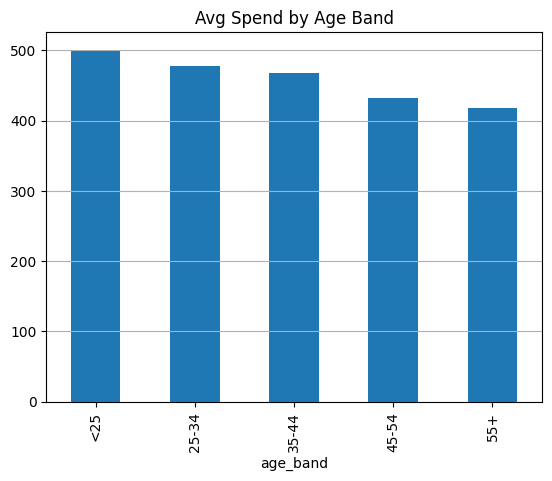

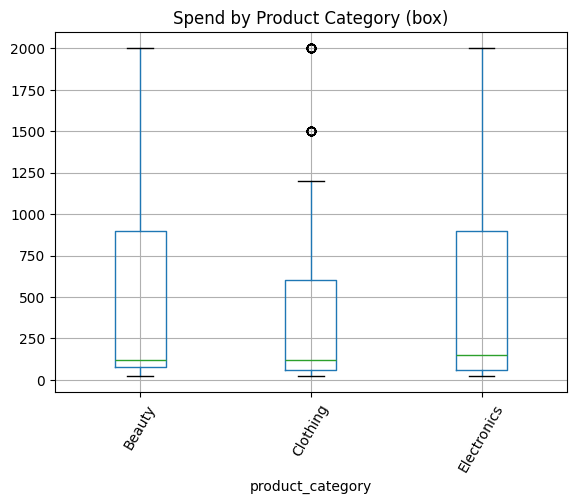

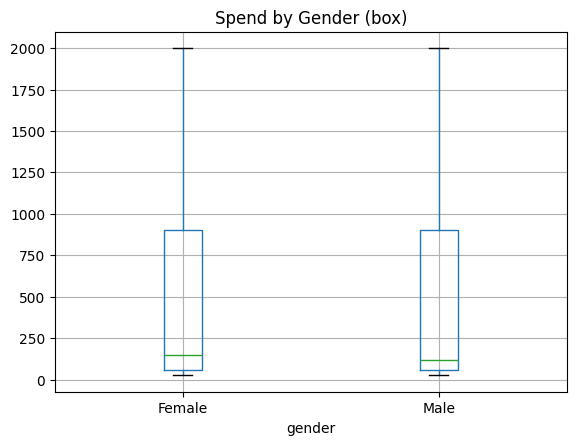

In [ ]:
df['age_band'] = pd.cut(df[col("age")], bins=[0,24,34,44,54,200],
                        labels=['<25','25-34','35-44','45-54','55+'])
df.groupby('age_band')[target].mean().sort_index().plot(kind='bar')
plt.title('Avg Spend by Age Band')
plt.grid(True, axis='y')
plt.show()

if col("product_category"):
    df.boxplot(column=target, by=col("product_category"), rot=60)
    plt.title("Spend by Product Category (box)"); plt.suptitle(""); plt.grid(True, axis='y'); plt.show()

if col("gender"):
    df.boxplot(column=target, by=col("gender"))
    plt.title("Spend by Gender (box)"); plt.suptitle(""); plt.grid(True, axis='y'); plt.show()

# 11) Relationship Grids


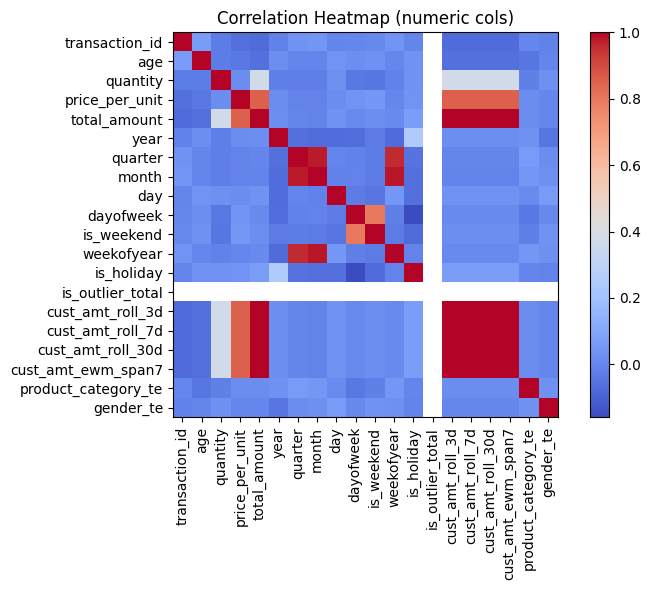

In [ ]:
# Correlation heatmap
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
plt.title("Correlation Heatmap (numeric cols)")

# imshow로 correlation 행렬을 그림
im = plt.imshow(corr, cmap="coolwarm", interpolation="nearest")

# 축 라벨
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)

# colorbar에는 im 객체를 넘겨야 함
plt.colorbar(im)

plt.tight_layout()
plt.show()

# 12) Simple Business-Oriented Tables


In [ ]:
# Busiest months/days (by total sales)
busiest_months = df.groupby("month")[target].sum().sort_values(ascending=False).head(5)
busiest_dows = df.groupby("dayofweek")[target].sum().sort_values(ascending=False).head(5)
print("\nTop 5 Months by Sales:\n", busiest_months)
print("\nTop 5 Days of Week by Sales (0=Mon):\n", busiest_dows)

# Product lines with highest sales (if category exists)
if cat:
    top_categories = df.groupby(cat)[target].sum().sort_values(ascending=False).head(10)
    print("\nTop 10 Product Categories by Sales:\n", top_categories)

# Simple customer segmentation proxy: top spenders
if cust:
    top_customers = df.groupby(cust)[target].sum().sort_values(ascending=False).head(10)
    print("\nTop 10 Customers by Total Spend:\n", top_customers)


Top 5 Months by Sales:
 month
5     53150.0
10    46580.0
12    44690.0
2     44060.0
1     36980.0
Name: total_amount, dtype: float64

Top 5 Days of Week by Sales (0=Mon):
 dayofweek
5    78815.0
0    70250.0
1    69440.0
4    66290.0
2    58770.0
Name: total_amount, dtype: float64

Top 10 Product Categories by Sales:
 product_category
Electronics    156905.0
Clothing       155580.0
Beauty         143515.0
Name: total_amount, dtype: float64

Top 10 Customers by Total Spend:
 customer_id
CUST015    2000.0
CUST412    2000.0
CUST970    2000.0
CUST547    2000.0
CUST281    2000.0
CUST416    2000.0
CUST420    2000.0
CUST927    2000.0
CUST447    2000.0
CUST342    2000.0
Name: total_amount, dtype: float64


                   mean  median  count
is_holiday                            
0           1310.933735  1030.0    332
1           1597.692308  1200.0     13

Avg sales lift on holidays: 21.9%


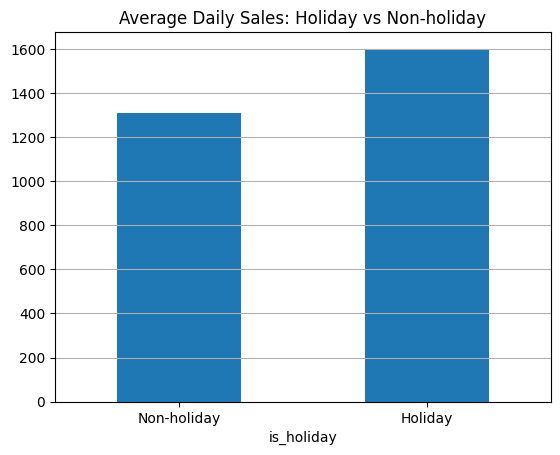

In [ ]:
# Holiday impact: avg daily sales lift
day_sales = df.groupby('date')[target].sum().reset_index()
day_sales['is_holiday'] = df.groupby('date')['is_holiday'].max().values  # 일자 단위 플래그
summary = day_sales.groupby('is_holiday')[target].agg(['mean','median','count'])
lift = (summary.loc[1,'mean'] / summary.loc[0,'mean'] - 1) * 100
print(summary)
print(f"\nAvg sales lift on holidays: {lift:.1f}%")

# (선택) 시각화
ax = summary['mean'].plot(kind='bar')
ax.set_xticklabels(['Non-holiday','Holiday'], rotation=0)
plt.title('Average Daily Sales: Holiday vs Non-holiday')
plt.grid(True, axis='y'); plt.show()

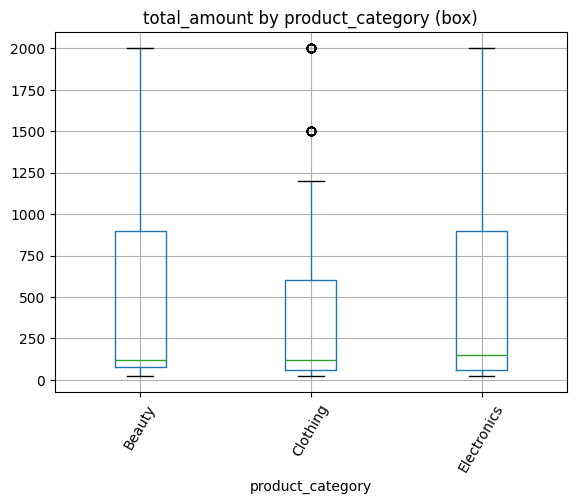

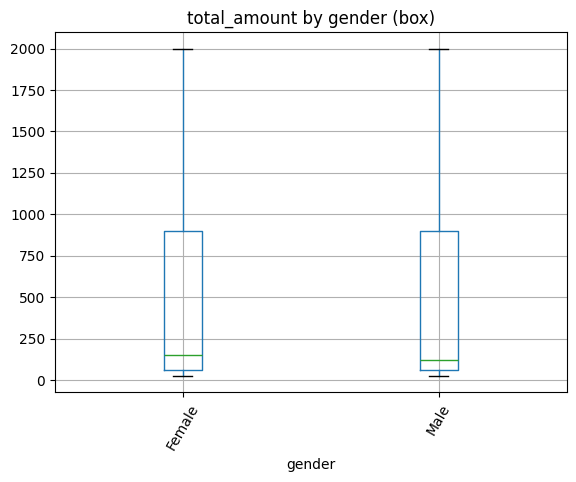

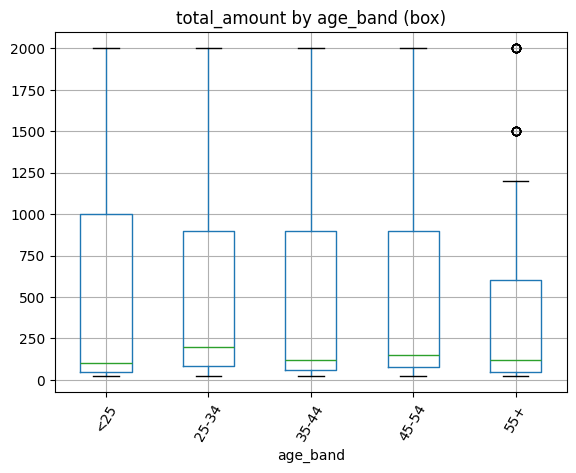

In [ ]:
# 연령대 구간화
df['age_band'] = pd.cut(df['age'], bins=[0,24,34,44,54,200],
                        labels=['<25','25-34','35-44','45-54','55+'])

# 박스플롯 예시
for col in ['product_category','gender','age_band']:
    if col in df.columns:
        df.boxplot(column=target, by=col, rot=60)
        plt.title(f'{target} by {col} (box)')
        plt.suptitle('')
        plt.grid(True, axis='y')
        plt.show()

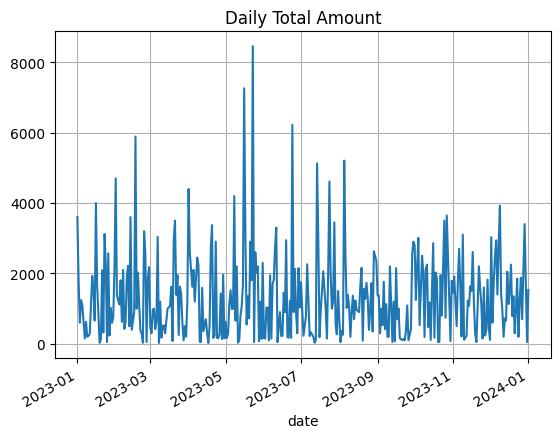

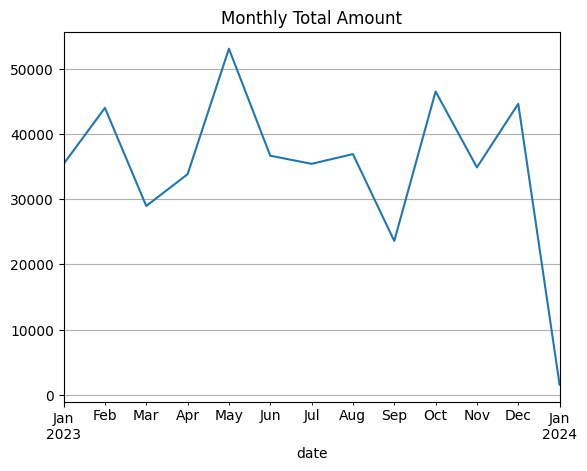

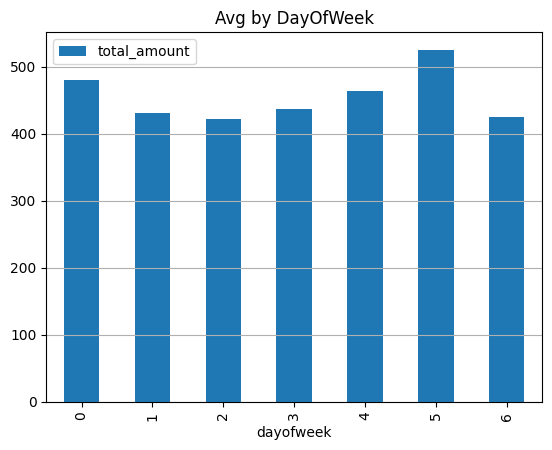

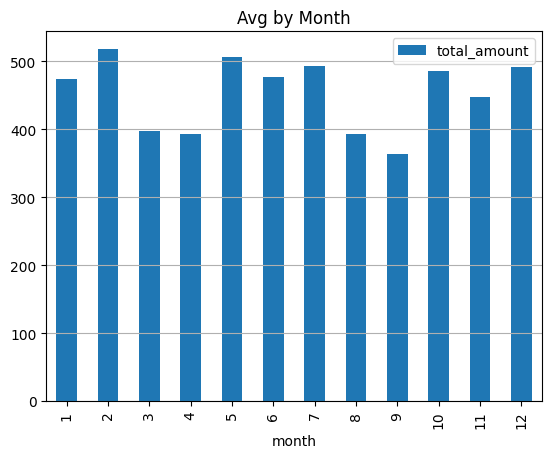

In [ ]:
# 일자별 합계
daily = df.groupby('date', as_index=True)[target].sum().sort_index()
daily.plot()
plt.title('Daily Total Amount')
plt.grid(True); plt.show()

# 월별
monthly = df.set_index('date').resample('M')[target].sum()
monthly.plot()
plt.title('Monthly Total Amount'); plt.grid(True); plt.show()

# 요일/월별 피벗
pivot_dw = df.pivot_table(index='dayofweek', values=target, aggfunc='mean')
pivot_dw.plot(kind='bar'); plt.title('Avg by DayOfWeek'); plt.grid(True, axis='y'); plt.show()

pivot_m = df.pivot_table(index='month', values=target, aggfunc='mean')
pivot_m.plot(kind='bar'); plt.title('Avg by Month'); plt.grid(True, axis='y'); plt.show()

MAE: 0.0
R2 : 1.0
cust_amt_roll_30d     0.257687
cust_amt_roll_7d      0.245892
cust_amt_roll_3d      0.242167
cust_amt_ewm_span7    0.240678
price_per_unit        0.007386
quantity              0.006190
transaction_id        0.000000
age                   0.000000
year                  0.000000
quarter               0.000000
month                 0.000000
weekofyear            0.000000
is_weekend            0.000000
dayofweek             0.000000
day                   0.000000
dtype: float64


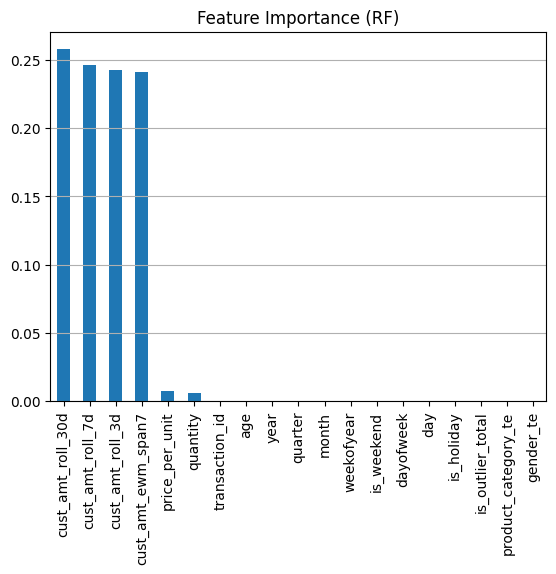

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 특징/타깃
y = df[target].astype(float)
# 누출 방지: target과 선형 종속인 원시 컬럼 제거(예: total_amount = quantity*price_per_unit인 경우)
X = df.drop(columns=[target])

# 숫자/범주 처리 끝났다면 결측 제거
X = X.select_dtypes(include=[np.number]).fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
print("MAE:", mean_absolute_error(y_test, pred))
print("R2 :", r2_score(y_test, pred))

imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(imp.head(15))

ax = imp.head(20).plot(kind='bar')
plt.title('Feature Importance (RF)')
plt.grid(True, axis='y')
plt.show()
